# Random Forest First Trial
## Summary of Tasks:
1. Encode feature variables
2. Train random forest model
3. Use grid search to find best hyperparameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/bank.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   41188 non-null  int64  
 1   duration              41188 non-null  int64  
 2   campaign              41188 non-null  int64  
 3   pdays                 41188 non-null  int64  
 4   previous              41188 non-null  int64  
 5   emp.var.rate          41188 non-null  float64
 6   cons.price.idx        41188 non-null  float64
 7   cons.conf.idx         41188 non-null  float64
 8   euribor3m             41188 non-null  float64
 9   nr.employed           41188 non-null  int64  
 10  y_encoded             41188 non-null  float64
 11  job_freq_encode       41188 non-null  float64
 12  education_encoded     41188 non-null  float64
 13  month_sin             41188 non-null  float64
 14  month_cos             41188 non-null  float64
 15  day_sin            

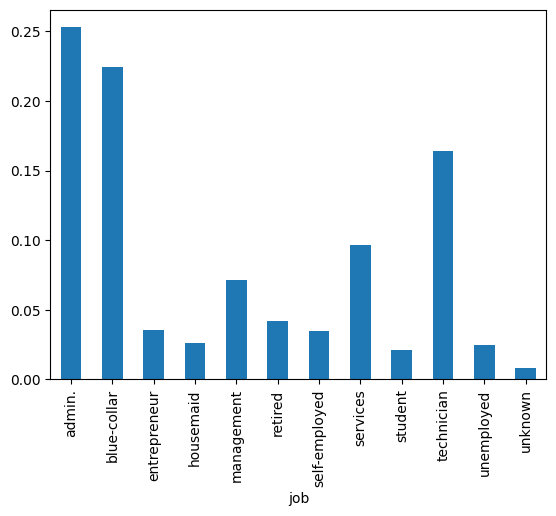

In [3]:
# Encoding categorical data
# Using ordinal encoding for y
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories=[['no','yes']])
data['y_encoded'] = encoder.fit_transform(data[['y']])
data['pdays'] = data['pdays'].replace(999, 0)


# Using dummy encoding to encode marital, poutcome, contact
to_dummy_cols = pd.DataFrame(data[['marital', 'poutcome','contact']])
dummy_cols = pd.get_dummies(to_dummy_cols)


# Using binary encoding for loan, housing, default, y
from category_encoders import BinaryEncoder 
encoder = BinaryEncoder(cols =['loan', 'housing', 'default']) 
# Transforming the column after fitting
newdata = encoder.fit_transform(data[['loan', 'housing', 'default']])

# Using frequency encoding for job
fq = data.groupby('job').size()/len(data)
# Mapping values to dataframe
data.loc[:, "{}_freq_encode".format('job')] = data['job'].map(fq)
fq.plot.bar(stacked=True)

# Using ordinal encoding for education
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories=[["illiterate","unknown","basic.4y","basic.6y","basic.9y","high.school","professional.course","university.degree"]])
data['education_encoded'] = encoder.fit_transform(data[['education']])

# Sin/cosine encoding for month, day_of_week
# Map categorical values to numerical values
month_mapping = {month: i+1 for i, month in enumerate(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                                                       'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])}
day_mapping = {day: i+1 for i, day in enumerate(['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'])}

data['month_num'] = data['month'].map(month_mapping)
data['day_num'] = data['day_of_week'].map(day_mapping)

# Sine and Cosine Encoding
data['month_sin'] = np.sin(2 * np.pi * data['month_num'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month_num'] / 12)
data['day_sin'] = np.sin(2 * np.pi * data['day_num'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_num'] / 7)


# concatenating dataframe
data = pd.concat([data, newdata, dummy_cols], axis = 1) 
# dropping old column 
data = data.drop(['loan', 'housing', 'default','y','marital', 'poutcome','contact','job','month', 'day_of_week', 'month_num', 'day_num','education'], axis = 1)

data.info()

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop(['y_encoded'], axis=1)
y = data[['y_encoded']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=31, test_size=0.2)


In [5]:
# Train basic random forest model now
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import *
rfc = RandomForestClassifier(n_jobs=-1, random_state=31)
rfc.fit(X_train, y_train)


# Checking scores
y_predict = rfc.predict(X_test)
y_predict_train = rfc.predict(X_train)
accuracy_test = accuracy_score(y_predict, y_test)
accuracy_train = accuracy_score(y_predict_train, y_train)
precision_test = precision_score(y_predict, y_test)
precision_train = precision_score(y_predict_train, y_train)
recall_test = recall_score(y_predict, y_test)
recall_train = recall_score(y_predict_train, y_train)
f1_test = f1_score(y_predict, y_test)
f1_train = f1_score(y_predict_train, y_train)

# Printing out results
# Predicting the accuracy score for Random Forest Classifier 
print('\n')
print('-------Random Forest Classifier-------')
print('accuracy for test is', accuracy_test)
print('accuracy for train is', accuracy_train)
print('\n')
print('precision for test is', precision_test)
print('precision for train is', precision_train)
print('\n')
print('recall for test is', recall_test)
print('recall for train is', recall_train)
print('\n')
print('f1 for test is', f1_test)
print('f1 for train is', f1_train)
print('\n')




-------Random Forest Classifier-------
accuracy for test is 0.9155134741442098
accuracy for train is 0.9999393019726859


precision for test is 0.4994438264738598
precision for train is 0.9994653835872761


recall for test is 0.6460431654676259
recall for train is 1.0


f1 for test is 0.5633626097867002
f1 for train is 0.9997326203208556


